In [111]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import time, gc
from tqdm import tqdm
gc.enable()
import matplotlib.pyplot as plt

In [4]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, given_test_set=None, emb_dim=200, test_size=0.1):
    """This function takes the dictionary of aligned entities between two KGs and their corresponding embeddings (as entity to vector dictionaries)
    and returns S, T, S_eval, T_eval, and R defined as follows:
    
    -- S: Normalized and scaled large subset of the source embeddings, i.e. the matrix of aligned entity embeddings in the first knowledge graph
    
    -- T: Normalized and scaled large subset of the matrix of aligned entity embeddings in the second knowledge graph
    
    -- S_eval and T_eval are portions of S and T sampled for evaluation if test_size > 0
    
    -- R: The rotation matrix that most closely maps S to T, i.e. ||A@S-T|| is minimized
    
    The mean and standard deviation of S, T are also returned
    """
    if test_size > 0:
        if given_test_set is None:
            train_ents, eval_ents = train_test_split(list(alignment_dict.keys()), test_size=test_size, random_state=42)
        else:
            eval_ents = given_test_set
            train_ents = list(set(alignment_dict.keys())-set(eval_ents))
    else:
        train_ents = alignment_dict.keys()
        
    S = np.empty((len(train_ents), emb_dim))
    T = np.empty((len(train_ents), emb_dim))
    if test_size > 0:
        S_eval = np.empty((len(eval_ents), emb_dim))
        T_eval = np.empty((len(eval_ents), emb_dim))

    for i, key in tqdm(enumerate(train_ents), total=len(train_ents), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    if test_size > 0:
        for i, key in tqdm(enumerate(eval_ents), total=len(eval_ents), desc='Computing S_eval and T_eval'):
            S_eval[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
            T_eval[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    print('\nNow computing R...')
    # Center and scale data
    mean_S = S.mean(axis=0)
    mean_T = T.mean(axis=0)
    scale_S = np.sqrt(((S-mean_S)**2).sum()/S.shape[0]) # scale, see https://en.wikipedia.org/wiki/Procrustes_analysis
    scale_T = np.sqrt(((T-mean_T)**2).sum()/T.shape[0])
    print('Scale S: ', scale_S)
    
    t0 = time.time()
    R, loss = orthogonal_procrustes((S-mean_S)/scale_S, (T-mean_T)/scale_T, check_finite=True)
    print('\nCompleted after '+str(time.time()-t0)+' seconds')
    print('Alignment loss: ', loss)
    if test_size > 0:
        return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, (S_eval-mean_S)/scale_S, (T_eval-mean_T)/scale_T, R
        #return scale_S, scale_T, mean_S, mean_T, S, T, S_eval, T_eval, R
    else:
        return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, R


In [5]:
EnFr_shallom_embs_v1 = pd.read_csv('Shallom_EnFr_15K_V1/Shallom_entity_embeddings.csv')

In [6]:
Fr_shallom_embs_v1 = EnFr_shallom_embs_v1[EnFr_shallom_embs_v1['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

In [7]:
En_shallom_embs_v1 = EnFr_shallom_embs_v1.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v1.shape[0]),\
                                                            np.array(Fr_shallom_embs_v1.index))].set_index('Unnamed: 0')

In [8]:
Fr_shallom_embs_v1 = Fr_shallom_embs_v1.set_index('Unnamed: 0')

In [9]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/ent_links') as file:
    en_to_fr_ents_v1 = file.read().strip().split('\n')
en_to_fr_ents_v1 = dict([line.split('\t') for line in en_to_fr_ents_v1])

In [10]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v1,\
                                                                                    En_shallom_embs_v1, Fr_shallom_embs_v1, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 15000/15000 [00:02<00:00, 5523.46it/s]



Now computing R...
Scale S:  7.246380617560009

Completed after 0.23187518119812012 seconds
Alignment loss:  5129.7868504241305


## 2D

In [18]:
import seaborn as sns
sns.set_theme(style="darkgrid")

### PCA before alignment

In [19]:
pca_before_fr = PCA(n_components=2)
reduced_embs_fr = pca_before_fr.fit_transform(Fr_shallom_embs_v1.values)

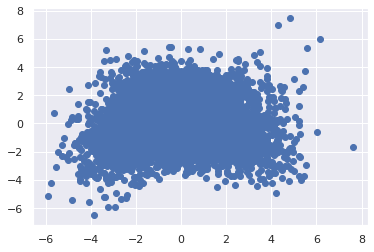

In [20]:
plt.scatter(reduced_embs_fr[:,0], reduced_embs_fr[:,1])
plt.savefig("fr_pca_full.png")
plt.show()

In [21]:
pca_before_en = PCA(n_components=2)
reduced_embs_en =  pca_before_en.fit_transform(En_shallom_embs_v1.values)

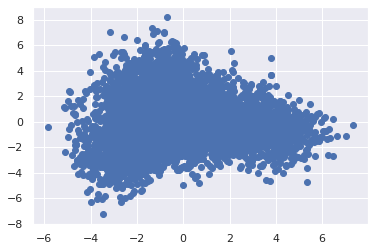

In [22]:
plt.scatter(reduced_embs_en[:,0], reduced_embs_en[:,1])
plt.savefig("en_pca_full.png")
plt.show()

### PCA of universal embeddings

In [23]:
pca = PCA(n_components=2)
reduced_uni_embs = pca.fit_transform((S@R+T)/2)

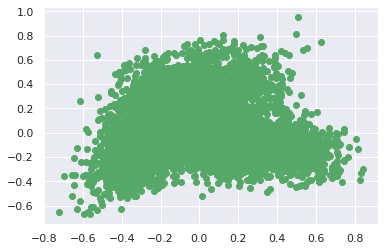

In [24]:
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g')
plt.savefig("universal_pca_full.png")
plt.show()

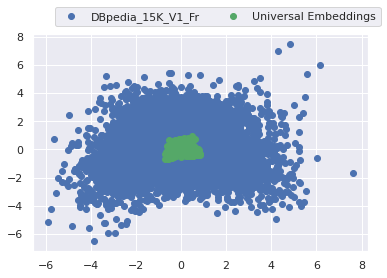

In [25]:
## French embeddings vs Universal embeddings
plt.scatter(reduced_embs_fr[:,0], reduced_embs_fr[:,1]);
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g');
plt.legend(('DBpedia_15K_V1_Fr', 'Universal Embeddings'), bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=2);

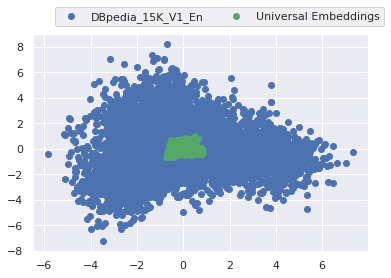

In [26]:
## English embeddings vs Universal embeddings
plt.scatter(reduced_embs_en[:,0], reduced_embs_en[:,1]);
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g');
plt.legend(('DBpedia_15K_V1_En', 'Universal Embeddings'), bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=2);

In [51]:
def search(string, Iterator_of_strings):
    string = string.replace(" ", "_")
    def __score(string1, string2):
        imax = len(string1)
        for i in range(1,imax+1)[::-1]:
            if string1[:i] in string2:
                return i
        return 0.0
    scores = {}
    for candidate in Iterator_of_strings:
        scores[candidate] = __score(string.lower(), candidate.lower())
    return sorted(list(scores.keys()), key=lambda x: -scores[x])

In [64]:
search("Trump", en_to_fr_ents_v1.keys())[:50]

['http://dbpedia.org/resource/A_Distant_Trumpet',
 'http://dbpedia.org/resource/Sounding_the_Seventh_Trumpet',
 'http://dbpedia.org/resource/Donald_Trump',
 'http://dbpedia.org/resource/Percussion_instrument',
 'http://dbpedia.org/resource/Anuthatantrum',
 'http://dbpedia.org/resource/Instrumental_rock',
 'http://dbpedia.org/resource/Trumbo_(2015_film)',
 'http://dbpedia.org/resource/Flying_(Beatles_instrumental)',
 'http://dbpedia.org/resource/Aerodynamic_(instrumental)',
 'http://dbpedia.org/resource/Instrumental',
 'http://dbpedia.org/resource/Obscured_by_Clouds_(instrumental)',
 'http://dbpedia.org/resource/Embryonic_Journey_(instrumental)',
 'http://dbpedia.org/resource/Quicksilver_(instrumental)',
 'http://dbpedia.org/resource/The_True_Meaning',
 'http://dbpedia.org/resource/A_Brand_You_Can_Trust',
 'http://dbpedia.org/resource/In_Gorbachev_We_Trust',
 'http://dbpedia.org/resource/Trun,_Switzerland',
 'http://dbpedia.org/resource/The_Truth_(Beanie_Sigel_album)',
 'http://dbpedia.

## Choose some entities and visualize embeddings

In [ ]:
# physics, physicist, Nobel_prize_in_physics, Obama, Donald Trump

In [22]:
En_version = ['http://dbpedia.org/resource/Nobel_Prize_in_Physics', 
              'http://dbpedia.org/resource/Physics', 'http://dbpedia.org/resource/Physicist',
              'http://dbpedia.org/resource/Barack_Obama','http://dbpedia.org/resource/Donald_Trump'
             ]
chosen_entities = dict(list(filter(lambda x: x[0] in En_version, en_to_fr_ents_v1.items())))

In [23]:
chosen_entities

{'http://dbpedia.org/resource/Barack_Obama': 'http://fr.dbpedia.org/resource/Barack_Obama',
 'http://dbpedia.org/resource/Nobel_Prize_in_Physics': 'http://fr.dbpedia.org/resource/Prix_Nobel_de_physique',
 'http://dbpedia.org/resource/Donald_Trump': 'http://fr.dbpedia.org/resource/Donald_Trump',
 'http://dbpedia.org/resource/Physics': 'http://fr.dbpedia.org/resource/Physique',
 'http://dbpedia.org/resource/Physicist': 'http://fr.dbpedia.org/resource/Physicien'}

### French DBpedia

In [ ]:
#sns.set_theme(style="darkgrid")

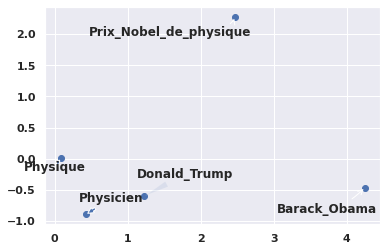

In [70]:
fr_ids = [list(Fr_shallom_embs_v1.index).index(e) for e in chosen_entities.values()]
names = [e.split('/')[-1] for e in chosen_entities.values()]
x_i = reduced_embs_fr[fr_ids,0]
y_i = reduced_embs_fr[fr_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots()
ax.scatter(x_i, y_i);
ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-1.2, y_i[0]-0.4), 
    arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="angle3,angleA=4,angleB=45"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]-2, y_i[1]-0.3), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-0.1, y_i[2]+0.3), 
    arrowprops = dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]-0.5, y_i[3]-0.2), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-0.1, y_i[4]+0.2),
    arrowprops = dict(arrowstyle="simple"))
plt.savefig("fr_pca.pdf", bbox_inches='tight')
plt.show()

### English DBpedia

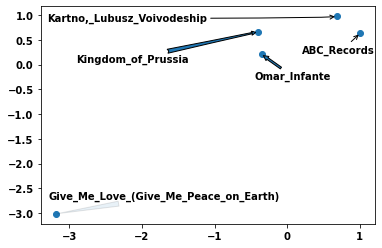

In [223]:
en_ids = [list(En_shallom_embs_v1.index).index(e) for e in chosen_entities]
names = [e.split('/')[-1] for e in chosen_entities]
x_i = reduced_embs_en[en_ids,0]
y_i = reduced_embs_en[en_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots()
ax.scatter(x_i, y_i);
ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-0.8, y_i[0]-0.4), 
    arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="angle3,angleA=4,angleB=45"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]-4, y_i[1]-0.1), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-0.1, y_i[2]+0.3), 
    arrowprops = dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]-2.5, y_i[3]-0.6), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-0.1, y_i[4]-0.5),
    #bbox=dict(boxstyle="round", alpha=0.1), 
    arrowprops = dict(arrowstyle="simple"))
plt.savefig("en_pca.pdf", bbox_inches='tight')
plt.show()

### Universal Embeddings

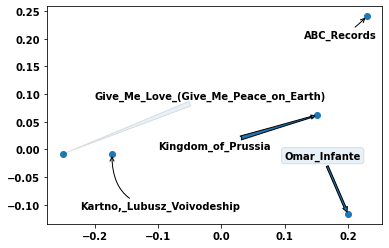

In [224]:
en_ids = [list(En_shallom_embs_v1.index).index(e) for e in chosen_entities]
names = [e.split('/')[-1] for e in chosen_entities]
x_i = reduced_uni_embs[en_ids,0]
y_i = reduced_uni_embs[en_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots()
ax.scatter(x_i, y_i);

ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-0.1, y_i[0]-0.04), 
    arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="angle3,angleA=4,angleB=45"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]-0.05, y_i[1]-0.1), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]+0.05, y_i[2]+0.1), 
    arrowprops = dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]-0.25, y_i[3]-0.06), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-0.1, y_i[4]+0.1),
    bbox=dict(boxstyle="round", alpha=0.1), 
    arrowprops = dict(arrowstyle="simple"))
plt.savefig("universal_pca.pdf", bbox_inches='tight')
plt.show()

## Plot with t-SNE

In [13]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [11]:
tsne = TSNE(n_components=2)
reduced_embs_fr = tsne.fit_transform(Fr_shallom_embs_v1.values)

/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



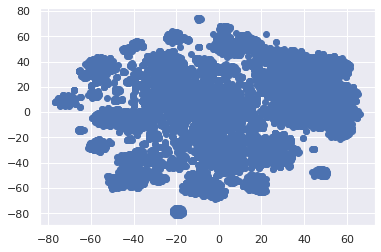

In [14]:
plt.scatter(reduced_embs_fr[:,0], reduced_embs_fr[:,1])
plt.savefig("fr_tsne_full.png")
plt.show()

In [15]:
tsne = TSNE(n_components=2)
reduced_embs_en = tsne.fit_transform(En_shallom_embs_v1.values)

/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



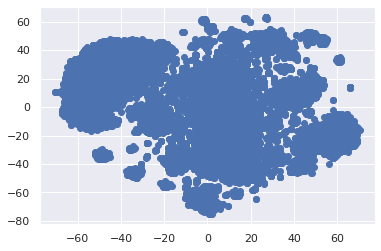

In [16]:
plt.scatter(reduced_embs_en[:,0], reduced_embs_en[:,1])
plt.savefig("en_tsne_full.png")
plt.show()

In [17]:
tsne = TSNE(n_components=2)
reduced_uni_embs = tsne.fit_transform((S@R+T)/2)

/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



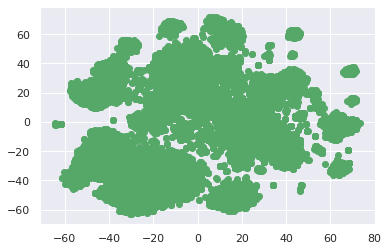

In [18]:
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g')
plt.savefig("universal_tsne_full.png")
plt.show()

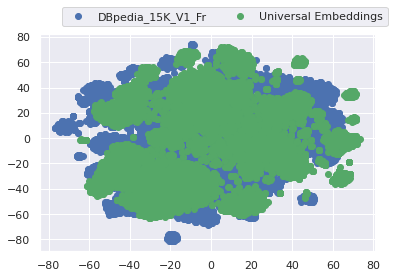

In [19]:
## Frenc embeddings vs Universal embeddings
plt.scatter(reduced_embs_fr[:,0], reduced_embs_fr[:,1]);
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g');
plt.legend(('DBpedia_15K_V1_Fr', 'Universal Embeddings'), bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=2);

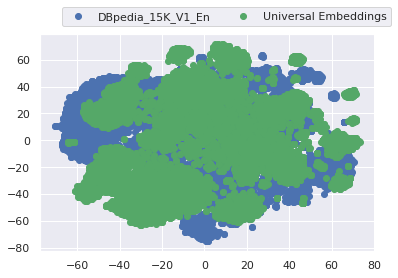

In [20]:
## English embeddings vs Universal embeddings
plt.scatter(reduced_embs_en[:,0], reduced_embs_en[:,1]);
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g');
plt.legend(('DBpedia_15K_V1_En', 'Universal Embeddings'), bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=2);

### Choose and visualize some entities

In [ ]:
En_version = ['http://dbpedia.org/resource/Nobel_Prize_in_Physics', 
              'http://dbpedia.org/resource/Physics', 'http://dbpedia.org/resource/Physicist',
              'http://dbpedia.org/resource/Barack_Obama','http://dbpedia.org/resource/Donald_Trump'
             ]
chosen_entities = dict(list(filter(lambda x: x[0] in En_version, en_to_fr_ents_v1.items())))

In [28]:
names

['Barack_Obama',
 'Prix_Nobel_de_physique',
 'Donald_Trump',
 'Physique',
 'Physicien']

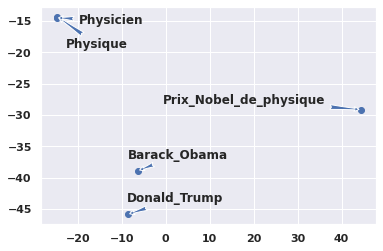

In [93]:
fr_ids = [list(Fr_shallom_embs_v1.index).index(e) for e in chosen_entities.values()]
names = [e.split('/')[-1] for e in chosen_entities.values()]
x_i = reduced_embs_fr[fr_ids,0]
y_i = reduced_embs_fr[fr_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots()
ax.scatter(x_i, y_i);
ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-2.2, y_i[0]+2), 
    arrowprops=dict(arrowstyle="fancy"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]-45, y_i[1]+1), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-0.1, y_i[2]+2), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]+2, y_i[3]-5), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]+5, y_i[4]-1),
    arrowprops = dict(arrowstyle="fancy"))
plt.savefig("fr_tsne.pdf", bbox_inches='tight')
plt.show()

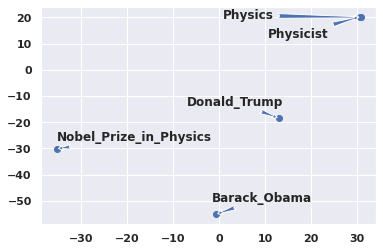

In [92]:
en_ids = [list(En_shallom_embs_v1.index).index(e) for e in chosen_entities]
names = [e.split('/')[-1] for e in chosen_entities]
x_i = reduced_embs_en[en_ids,0]
y_i = reduced_embs_en[en_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots()
ax.scatter(x_i, y_i);
ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-0.8, y_i[0]+5), 
    arrowprops=dict(arrowstyle="fancy"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1], y_i[1]+3), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-20, y_i[2]+5), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]-30, y_i[3]-0.6), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-20, y_i[4]-8),
    arrowprops = dict(arrowstyle="fancy"))
plt.savefig("en_tsne.pdf", bbox_inches='tight')
plt.show()

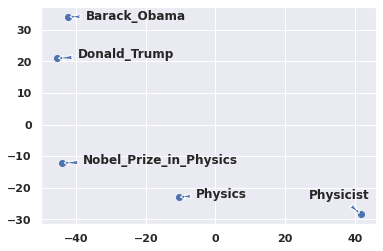

In [91]:
en_ids = [list(En_shallom_embs_v1.index).index(e) for e in chosen_entities]
names = [e.split('/')[-1] for e in chosen_entities]
x_i = reduced_uni_embs[en_ids,0]
y_i = reduced_uni_embs[en_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots()
ax.scatter(x_i, y_i);

ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]+5, y_i[0]-1), 
    arrowprops=dict(arrowstyle="fancy"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]+6, y_i[1]-0.1), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]+6, y_i[2]+0.1), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]+5, y_i[3]), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-15, y_i[4]+5), 
    arrowprops = dict(arrowstyle="fancy"))
plt.savefig("universal_tsne.pdf", bbox_inches='tight')
plt.show()